### Introduction

This is the best I could do with a fastai tabular model. It contains a number of features particular to both the user and the question at that point in time. Then for inference there is a dictionary filled with each user's history and their current state. This helped dramatically in improving my LB score. I did pull code from a bunch of different notebooks, so I'll reference the original material as it comes up. 

A big problem with using a fastai tabular model is building the TabularPandas during inference. It takes way too long with certain categorical features, so we just can't use them. In training I was able to use user_id as a categorical feature, which seemed really useful. But it's too slow to use during inference.

A big thanks to all the users out there sharing kernels, I've learned a ton from these notebooks and this competition. 

In [1]:
from sklearn.metrics import roc_auc_score     
from fastai.tabular.all import *
import gc
import fastai
from tqdm.notebook import tqdm as tqdm

In [2]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything(42)

### Initial Load

In [3]:
%%time

train_df = pd.read_feather('/kaggle/input/riid-with-attempts-feather/train_with_attempts')
# The dataframe is already sorted by time
train_df.drop('timestamp', axis=1, inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99271300 entries, 0 to 99271299
Data columns (total 11 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   answered_correctly              int8   
 3   prior_question_elapsed_time     float32
 4   prior_question_had_explanation  bool   
 5   attempts                        int8   
 6   user_correctness                float32
 7   user_count                      int16  
 8   content_correctness             float32
 9   content_count                   int32  
 10  hmean_user_content              float32
dtypes: bool(1), float32(4), int16(2), int32(2), int8(2)
memory usage: 2.9 GB
CPU times: user 2.67 s, sys: 16.2 s, total: 18.9 s
Wall time: 25.2 s


### Feature generation

In [4]:
target = 'answered_correctly'

In [5]:
# https://www.kaggle.com/shoheiazuma/riiid-lgbm-starter
# This notebook helped me create features that didn't leak future information, which was very helpful
content_agg = pd.read_feather('/kaggle/input/riid-with-attempts-feather/content_agg_feather')
content_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   content_id  13523 non-null  int64  
 1   sum         13523 non-null  float64
 2   count       13523 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 317.1 KB


In [6]:
%%time
questions_df = pd.read_csv(
    '../input/riiid-test-answer-prediction/questions.csv', 
    usecols=[0, 1, 3, 4],
    dtype={'question_id': 'int16', 'bundle_id': 'int16', 'part': 'int8', 'tags': 'object'}
)

# Split the tags into their own individual columns
tags = questions_df['tags'].str.split(' ', n=10, expand=True)
tags.columns = ['tags1', 'tags2', 'tags3', 'tags4', 'tags5', 'tags6']
# Drop the original tags column plus unimportant tags from feature importance
questions_df.drop(['tags'], axis=1, inplace=True)
# While investgating feature importance, tags2 and tags3 seemed to be the most useful. 
tags.drop(['tags1', 'tags4', 'tags5', 'tags6'], axis=1, inplace=True)
# Concat the individual tag columns
questions_df = pd.concat([questions_df, tags], axis=1)

questions_df['tags2'] = pd.to_numeric(questions_df['tags2'], errors='coerce',downcast='integer').fillna(-1)
questions_df['tags3'] = pd.to_numeric(questions_df['tags3'], errors='coerce',downcast='integer').fillna(-1)
questions_df['tags2'] = questions_df['tags2'].astype('uint16')
questions_df['tags3'] = questions_df['tags3'].astype('uint16')

train_df = pd.merge(train_df, questions_df, left_on='content_id', right_on='question_id', how='left')
train_df.drop(columns=['question_id'], inplace=True)

# del questions_df
del tags
gc.collect()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99271300 entries, 0 to 99271299
Data columns (total 15 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   user_id                         int32  
 1   content_id                      int16  
 2   answered_correctly              int8   
 3   prior_question_elapsed_time     float32
 4   prior_question_had_explanation  bool   
 5   attempts                        int8   
 6   user_correctness                float32
 7   user_count                      int16  
 8   content_correctness             float32
 9   content_count                   int32  
 10  hmean_user_content              float32
 11  bundle_id                       int16  
 12  part                            int8   
 13  tags2                           uint16 
 14  tags3                           uint16 
dtypes: bool(1), float32(4), int16(3), int32(2), int8(3), uint16(2)
memory usage: 4.3 GB
CPU times: user 25.5 s, sys: 8.

In [7]:
cat = ['part', 'tags2', 'tags3', 'bundle_id']
cont = ['user_count', 'user_correctness', 'content_count', 'content_correctness', 'prior_question_elapsed_time', 
        'attempts', 'hmean_user_content']

features = cat + cont

In [8]:
def replace_na(x):
    x = x.replace([np.inf, -np.inf], np.nan)

    x['tags2'].fillna(255, inplace=True)
    x['tags3'].fillna(255, inplace=True)

    return x.fillna(0)

In [9]:
# Get rid of all the columns we won't be needing
train_df = train_df[features + [target]]
train_df = replace_na(train_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99271300 entries, 0 to 99271299
Data columns (total 12 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   part                         int8   
 1   tags2                        uint16 
 2   tags3                        uint16 
 3   bundle_id                    int16  
 4   user_count                   int16  
 5   user_correctness             float32
 6   content_count                int32  
 7   content_correctness          float32
 8   prior_question_elapsed_time  float32
 9   attempts                     int8   
 10  hmean_user_content           float32
 11  answered_correctly           int8   
dtypes: float32(4), int16(2), int32(1), int8(3), uint16(2)
memory usage: 3.6 GB


In [10]:
# I use the last quarter of the data to train on, with the last tenth of that as validation. Given time and spatial restrictions, this seems the most useful
thresh = int(0.75 * len(train_df))
train_df = train_df.iloc[thresh:].reset_index(drop=True)
train_range = list(range(len(train_df) - int(len(train_df) / 10)))
valid_range = list(range(len(train_df) - int(len(train_df) / 10), len(train_df)))
splits = (train_range, valid_range)

gc.collect()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24817825 entries, 0 to 24817824
Data columns (total 12 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   part                         int8   
 1   tags2                        uint16 
 2   tags3                        uint16 
 3   bundle_id                    int16  
 4   user_count                   int16  
 5   user_correctness             float32
 6   content_count                int32  
 7   content_correctness          float32
 8   prior_question_elapsed_time  float32
 9   attempts                     int8   
 10  hmean_user_content           float32
 11  answered_correctly           int8   
dtypes: float32(4), int16(2), int32(1), int8(3), uint16(2)
memory usage: 733.7 MB


In [11]:
%%time

EPOCHS=5
BATCH_SIZE=2048

pd.options.mode.chained_assignment=None
to = TabularPandas(train_df, [Categorify, Normalize, FillMissing], cat, cont, target, splits=splits, inplace=True)
dls = to.dataloaders(BATCH_SIZE)

CPU times: user 17.8 s, sys: 3.67 s, total: 21.5 s
Wall time: 20.7 s


epoch,train_loss,valid_loss,my_auc,time
0,0.179579,0.176318,0.765313,22:38
1,0.178399,0.175412,0.768040,22:18
2,0.176582,0.175136,0.768540,22:25
3,0.176639,0.174951,0.768784,22:34
4,0.175678,0.175027,0.768566,22:30


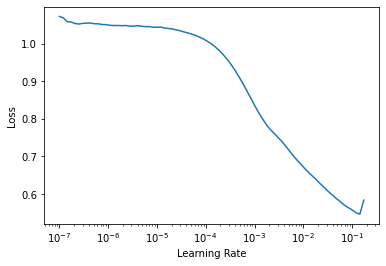

In [12]:
# https://www.kaggle.com/gilfernandes/fastai-single-nn
# my_auc and predict_batch are both from this kernel
def my_auc(inp, targ):
    "Simple wrapper around scikit's roc_auc_score function for regression problems"
    inp,targ = flatten_check(inp,targ)
    return roc_auc_score(targ.cpu().numpy(), inp.cpu().numpy())

learn = tabular_learner(dls, layers=[200,200], metrics=my_auc)

lr_find_res = learn.lr_find()

learn.fit_one_cycle(EPOCHS, lr_find_res.lr_min / 10)

In [13]:
def predict_batch(self, df):
    dl = self.dls.test_dl(df)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
    return preds.numpy()

setattr(learn, 'predict_batch', predict_batch)

In [14]:
del dls
del to
del train_df
gc.collect()

11100

In [15]:
%%time
train_df = pd.read_feather('/kaggle/input/riid-with-attempts-feather/train_with_attempts')
train_df = train_df.loc[train_df['answered_correctly'] != -1]
train_df.sort_values('timestamp', inplace=True)
train_df.drop(['prior_question_had_explanation', 'prior_question_elapsed_time', 'timestamp', 'attempts', 
               'user_correctness', 'user_count', 'content_correctness', 'content_count', 'hmean_user_content'], axis=1, inplace=True)
train_df.reset_index(drop=True, inplace=True)
gc.collect()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99271300 entries, 0 to 99271299
Data columns (total 3 columns):
 #   Column              Dtype
---  ------              -----
 0   user_id             int32
 1   content_id          int16
 2   answered_correctly  int8 
dtypes: int16(1), int32(1), int8(1)
memory usage: 662.7 MB
CPU times: user 16.2 s, sys: 15.1 s, total: 31.3 s
Wall time: 31.3 s


In [16]:
%%time
# https://www.kaggle.com/markwijkhuizen/riiid-training-and-prediction-using-a-state
# This is an altered piece from that notebook to be keep track of user states

# Creates a dictionary of dictionaries for each user and their attributes
def user_states(df):
    mean_user_accuracy = train_df.groupby('user_id')[target].mean().values
    answered_correctly_user = train_df.groupby('user_id')[target].sum().values
    answered_user = train_df.groupby('user_id')[target].count().values  

    state = dict()
    for user_id in train_df['user_id'].sort_values().unique():
        state[user_id] = {}
    total = len(state.keys())

    user_content = train_df.groupby('user_id')['content_id'].apply(np.array).apply(np.sort).apply(np.unique)
    # The number of attempts made for each of those unique combinations
    user_attempts = train_df.groupby(['user_id', 'content_id'])[target].count().astype(np.uint8).groupby('user_id').apply(np.array).values

    for user_id, content, attempt in tqdm(zip(state.keys(), user_content, user_attempts),total=total):
        state[user_id]['user_content_attempts'] = dict(zip(content, attempt))

    del user_content, user_attempts
    gc.collect()

    for idx, user_id in enumerate(state.keys()):
        state[user_id]['user_correctness'] = mean_user_accuracy[idx]
        state[user_id]['user_sum'] = answered_correctly_user[idx]
        state[user_id]['user_count'] = answered_user[idx]
        
    return state
  
user_states = user_states(train_df)
del train_df
gc.collect()


CPU times: user 3min 46s, sys: 13 s, total: 3min 59s
Wall time: 3min 58s


0

In [17]:
import riiideducation

env = riiideducation.make_env()

iter_test = env.iter_test()
prior_test_df = None

In [18]:
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))

In [19]:
# https://www.kaggle.com/shoheiazuma/riiid-lgbm-starter
# The skeleton for this inference part was taken from the above notebook, including a number of modifications.

for (test_df, sample_prediction_df) in iter_test:
    y_preds = []
    
    # If test_df includes information about the previous chunk of data, update our states to reflect that
    if prior_test_df is not None:   
        prior_test_df[target] = eval(test_df['prior_group_answers_correct'].iloc[0])
        prior_test_df = prior_test_df[prior_test_df[target] != -1].reset_index(drop=True)
        
        user_ids = prior_test_df['user_id'].values
        content_ids = prior_test_df['content_id'].values
        targets = prior_test_df[target].values
        
        for user_id, content_id, answered_correctly in zip(user_ids, content_ids, targets):
            user_states[user_id]['user_sum'] += answered_correctly
            user_states[user_id]['user_count'] += 1
            user_states[user_id]['user_content_attempts'][content_id] += 1
            content_sum_dict[content_id] += answered_correctly
            content_count_dict[content_id] += 1
      
    prior_test_df = test_df.copy()
    
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
    
    test_df = pd.merge(test_df, questions_df, left_on='content_id', right_on='question_id', how='left')
    
    user_sum = np.zeros(len(test_df), dtype=np.int16)
    user_count = np.zeros(len(test_df), dtype=np.int16)
    content_sum = np.zeros(len(test_df), dtype=np.int32)
    content_count = np.zeros(len(test_df), dtype=np.int32)
    user_content_attempts = np.zeros(len(test_df), dtype=np.int8)
    
    for i, (user_id, content_id) in enumerate(zip(test_df['user_id'].values, test_df['content_id'].values)):
        # Handle new users and questions
        if user_id not in user_states.keys():
            user_states[user_id] = {'user_content_attempts':{user_id:0}, 
                                    'user_correctness':0, 
                                    'user_count':0, 
                                    'user_sum':0}
            
        if content_id not in user_states[user_id]['user_content_attempts'].keys():
            user_states[user_id]['user_content_attempts'][content_id] = 0
            
        user_sum[i] = user_states[user_id]['user_sum']
        user_count[i] = user_states[user_id]['user_count']
        user_content_attempts[i] = user_states[user_id]['user_content_attempts'][content_id]

        content_sum[i] = content_sum_dict[content_id]
        content_count[i] = content_count_dict[content_id]
 
    test_df['user_correctness'] = user_sum / user_count
    test_df['user_count'] = user_count
    
    test_df['content_count'] = content_count
    test_df['content_correctness'] = content_sum / content_count
    test_df['attempts'] = user_content_attempts
    test_df['hmean_user_content'] = 2 * (
                                            (test_df['user_correctness'] * test_df['content_correctness']) /
                                            (test_df['user_correctness'] + test_df['content_correctness'])
                                        ).astype('float32')

    test_df = replace_na(test_df)
    test_df[target] = learn.predict_batch(learn, test_df[features])

    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
